# Practical Machine Learning for Physicists
## Week 2 Exercise - Part 2
## Deadline Monday 9th November at 12pm (Noon)

For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

In [1]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Some style imports
import matplotlib.style 
import matplotlib as mpl

# Import some image handling/loading libraries
from scipy import ndimage

# Added for a progress bar
from tqdm import tqdm
import imageio

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)


2.6.0


In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target = np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test = get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    
    fig, ax = plt.subplots(1,2)
    
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [3]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

In [19]:
# Set up model
model=keras.models.Sequential()

# First down sampling, increase by 4 kernal, dimensions divied by 3 to 9x9, with batch norm
model.add(keras.layers.Conv2D(4,5,input_shape=(None,None,1), activation="relu",padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) 

# Second down sampling, stil 4 kernal, but dimensions divied by 3 to 3x3, with batch norm
model.add(keras.layers.Conv2D(4,5, activation="relu",padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))


model.add(keras.layers.BatchNormalization())

# Bottleneck 1 kernal, dimension 3x3, therefore 9 neurons
model.add(keras.layers.Conv2D(1,3, activation="relu",padding='same'))

model.add(keras.layers.BatchNormalization())


# Up sampling increase size by 3 to 9x9, convolution increase to 4 kernals
model.add(keras.layers.UpSampling2D(size=(3,3))) 
model.add(keras.layers.Conv2D(4,5, activation="relu",padding='same'))

# Up sampling increase size by 3 to 27x27, convolution stays to 4 kernals
model.add(keras.layers.UpSampling2D(size=(3,3))) # up
model.add(keras.layers.Conv2D(4,5, activation="relu",padding='same'))

model.add(keras.layers.BatchNormalization())

# Last convolution convert kernal to 1, so 27x27x1
model.add(keras.layers.Conv2D(1,5,activation="sigmoid",padding='same'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, None, None, 4)     104       
_________________________________________________________________
batch_normalization_13 (Batc (None, None, None, 4)     16        
_________________________________________________________________
average_pooling2d_7 (Average (None, None, None, 4)     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, None, None, 4)     404       
_________________________________________________________________
batch_normalization_14 (Batc (None, None, None, 4)     16        
_________________________________________________________________
average_pooling2d_8 (Average (None, None, None, 4)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, None, None, 4)    

In [20]:
#Now we can do the actual model training
steps=600
cost,y_target=generate_and_train(model,circle_generator,img_size=27,batchsize=50,steps=steps)

In [21]:
# Printing model neuron layers
print_layers(model,  y_target)

Layer 0: 2916 neurons /  (50, 27, 27, 4)
Layer 1: 2916 neurons /  (50, 27, 27, 4)
Layer 2: 324 neurons /  (50, 9, 9, 4)
Layer 3: 324 neurons /  (50, 9, 9, 4)
Layer 4: 324 neurons /  (50, 9, 9, 4)
Layer 5: 36 neurons /  (50, 3, 3, 4)
Layer 6: 36 neurons /  (50, 3, 3, 4)
Layer 7: 9 neurons /  (50, 3, 3, 1)
Layer 8: 9 neurons /  (50, 3, 3, 1)
Layer 9: 81 neurons /  (50, 9, 9, 1)
Layer 10: 324 neurons /  (50, 9, 9, 4)
Layer 11: 2916 neurons /  (50, 27, 27, 4)
Layer 12: 2916 neurons /  (50, 27, 27, 4)
Layer 13: 2916 neurons /  (50, 27, 27, 4)
Layer 14: 729 neurons /  (50, 27, 27, 1)


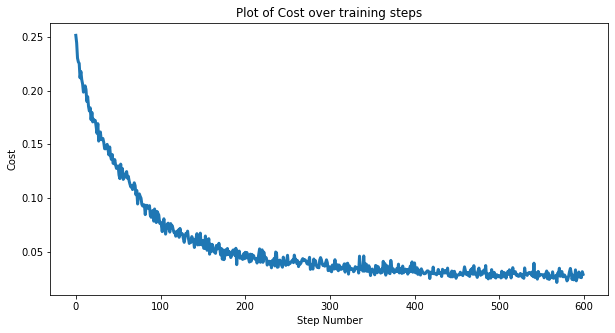

Cost value: 0.02877911552786827


In [22]:
#Plot the cost
stepArray=np.arange(steps) 

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(stepArray,cost,linewidth=3) 

ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title('Plot of Cost over training steps')
plt.show()

print('Cost value:',cost[-1])

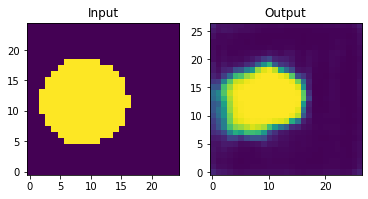

In [23]:
#Just for fun let's plot what the image looks like before any training
#Probably since our input image is just 1 or 0 the output even with random model weights and biases will
#have a circle imprint/
plot_test_image(model,circle_generator,25)

#### Comment:
- Achieved cost of 0.015; we have a bottle neck of 9 neurons and use batch normilisation to optimise. Batch normalization is to make the artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling. Using relu with single sigmoid at end gives best cost reduction.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.

In [24]:
# Set up model
model=keras.models.Sequential()

# First down sampling, increase by 4 kernal, dimensions divied by 3 to 9x9, with batch norm
model.add(keras.layers.Conv2D(4,5,input_shape=(None,None,1), activation="relu",padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same'))

# Second down sampling, stil 4 kernal, but dimensions divied by 3 to 3x3, with batch norm
model.add(keras.layers.Conv2D(4,5, activation="relu",padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) 
model.add(keras.layers.BatchNormalization())


# Bottleneck 3 kernal, with pooling to dimension 1x1, therefore 3 neurons
model.add(keras.layers.Conv2D(3,3, activation="relu",padding='same'))
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) 

# Up sampling increase size by 3 to 3x3, convolution increase to 4 kernals
model.add(keras.layers.UpSampling2D(size=(3,3)))
model.add(keras.layers.Conv2D(4,5, activation="relu",padding='same'))
model.add(keras.layers.BatchNormalization())

# Up sampling increase size by 3 to 9x9, convolution keeps 4 kernals
model.add(keras.layers.UpSampling2D(size=(3,3))) 
model.add(keras.layers.Conv2D(4,5, activation="relu",padding='same'))

# Up sampling increase size by 3 to 27x27, convolution stays to 4 kernals
model.add(keras.layers.UpSampling2D(size=(3,3))) 
model.add(keras.layers.Conv2D(4,5, activation="sigmoid",padding='same'))

# Last convolution convert kernal to 1, so 27x27x1
model.add(keras.layers.Conv2D(1,5,activation="sigmoid",padding='same'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='nadam')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, None, None, 4)     104       
_________________________________________________________________
batch_normalization_18 (Batc (None, None, None, 4)     16        
_________________________________________________________________
average_pooling2d_9 (Average (None, None, None, 4)     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, None, None, 4)     404       
_________________________________________________________________
average_pooling2d_10 (Averag (None, None, None, 4)     0         
_________________________________________________________________
batch_normalization_19 (Batc (None, None, None, 4)     16        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, None, None, 3)    

In [25]:
print_layers(model,  y_target)

Layer 0: 2916 neurons /  (50, 27, 27, 4)
Layer 1: 2916 neurons /  (50, 27, 27, 4)
Layer 2: 324 neurons /  (50, 9, 9, 4)
Layer 3: 324 neurons /  (50, 9, 9, 4)
Layer 4: 36 neurons /  (50, 3, 3, 4)
Layer 5: 36 neurons /  (50, 3, 3, 4)
Layer 6: 27 neurons /  (50, 3, 3, 3)
Layer 7: 3 neurons /  (50, 1, 1, 3)
Layer 8: 27 neurons /  (50, 3, 3, 3)
Layer 9: 36 neurons /  (50, 3, 3, 4)
Layer 10: 36 neurons /  (50, 3, 3, 4)
Layer 11: 324 neurons /  (50, 9, 9, 4)
Layer 12: 324 neurons /  (50, 9, 9, 4)
Layer 13: 2916 neurons /  (50, 27, 27, 4)
Layer 14: 2916 neurons /  (50, 27, 27, 4)
Layer 15: 729 neurons /  (50, 27, 27, 1)


In [ ]:
#Now we can do the actual model training
steps=600
cost,y_target=generate_and_train(model,circle_generator,img_size=27,batchsize=50,steps=steps)

In [ ]:
# Plot the cost
stepArray=np.arange(steps) 

fig, ax = plt.subplots()
ax.plot(stepArray,cost,linewidth=3) 

ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")
ax.set_title('Plot of Cost over training steps')
plt.show()

print('Cost value:',cost[-1])

In [ ]:
#Just for fun let's plot what the image looks like before any training
#Probably since our input image is just 1 or 0 the output even with random model weights and biases will
#have a circle imprint
plot_test_image(model,circle_generator,25)

#### Comment:
- Achieved cost of 0.02797 this is acceptable  low, as much tighter bottleneck makes network less effective. We use nadam optimiser as we get better optimisation of the network

#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)